In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from findthegap.gapper import Gapper
import torch
from popsims.plot_style import  plot_style
plot_style()

%matplotlib inline

In [2]:
#d=np.load('/users/caganze/streams_data.npy',  allow_pickle=True).flatten()[0]

In [3]:
def get_density(data, meshgrid, gridding_size, bw, nboot=2):
    meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in meshgrid]
    grid_data = np.hstack(meshgrid_ravel)
    
    mineigval_PiHPi_boots =[]
    maxeigval_PiHPi_boots =[]
    PiHPi_boots=[]
    dens_boots=[]
    
    for _ in range(nboot):

        #bootstrap --> actual bootstrapping now
        
        idx = np.random.randint(len(data), size=len(data))
        boot=data[idx,:]
        
        gapp=Gapper(boot, bw, bounds=bounds)
        
        dens=gapp.get_density(torch.tensor(grid_data),  requires_grad=False).flatten()
    
        PiHPis_grid = []
        eigval_PiHPi = [] 

        for pt in grid_data:
            _pihpi = gapp.get_PiHPi(pt) 
            _pihpi_eigval, _= np.linalg.eigh(_pihpi)
            PiHPis_grid.append(_pihpi)
            eigval_PiHPi.append(_pihpi_eigval)
           

        PiHPis_grid, eigval_PiHPi = np.array(PiHPis_grid), np.array(eigval_PiHPi)

        #option for using minium or maximum eigenvalue
        #if max_eigenvalue:
        max_eigval_PiHPi_k = np.nanmax(eigval_PiHPi, axis=1)
        #rescale everything between 0 and 1
        max_eigval_PiHPi_k = (max_eigval_PiHPi_k-np.nanmin(max_eigval_PiHPi_k))/(np.nanmax(max_eigval_PiHPi_k)-np.nanmin(max_eigval_PiHPi_k))

        #if not max_eigenvalue:
        min_eigval_PiHPi_k = np.nanmin(eigval_PiHPi, axis=1)
        min_eigval_PiHPi_k = (min_eigval_PiHPi_k-np.nanmin(min_eigval_PiHPi_k))/(np.nanmax(min_eigval_PiHPi_k)-np.nanmin(min_eigval_PiHPi_k))

        
        maxeigval_PiHPi_boots.append(max_eigval_PiHPi_k)
        mineigval_PiHPi_boots.append(min_eigval_PiHPi_k)
        PiHPi_boots.append(PiHPis_grid)
        dens_boots.append(dens)
        
    maxeigval_PiHPi_boots = np.array(maxeigval_PiHPi_boots)
    mineigval_PiHPi_boots = np.array(mineigval_PiHPi_boots)
    
    #median
    med_maxeigval_pihpi = np.median(maxeigval_PiHPi_boots, axis=0).reshape((gridding_size[0], gridding_size[1]))
    med_mineigval_pihpi = np.median(mineigval_PiHPi_boots, axis=0).reshape((gridding_size[0], gridding_size[1]))
    med_dens=np.nanmedian([np.array(x) for x in dens_boots], axis=0).reshape((gridding_size[0], gridding_size[1]))
    
    return {'density':med_dens,
            'meshgrid':meshgrid,
            'grid_data':grid_data,
            'max_eigen':med_maxeigval_pihpi,
            'min_eigen':med_mineigval_pihpi}

In [4]:
data0=np.loadtxt('/users/caganze/mock_data.csv',    delimiter=',')
data1=np.loadtxt('/users/caganze/mock_data_with_stream.csv',     delimiter=',')

In [20]:
dx=2.5
dy=1
bounds =np.array([[34.5-dx, 34.5+dx],
       [34.5-dy, 34.5+dy]])
gridding_size = [ 50, 20]

grid_linspace = [ np.linspace(bounds[d][0], bounds[d][1], gridding_size[d]) for d in range(2) ]

meshgrid = np.meshgrid(*grid_linspace, indexing='ij')

meshgrid_ravel = [ xi.ravel().reshape(-1,1) for xi in meshgrid]
grid_data = np.hstack(meshgrid_ravel)

#meshgrid

d=np.load('/users/caganze/streams_data.npy',  allow_pickle=True).flatten()[0]


data0=d['bckgd']['data'] #pick data that's 2 bandwidth larger
data1=d['streamgap']['data']

In [26]:
bounds

array([[32. , 37. ],
       [33.5, 35.5]])

/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/findthegap/quarticKDE.py:52: RuntimeWarning: divide by zero encountered in log
  self.logn = np.log(self.n)
/Users/caganze/opt/anaconda3/lib/python3.9/site-packages/findthegap/gapper.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_t = torch.tensor(points, dtype=torch.float32, requires_grad=requires_grad)
/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_7825/707752391.py:37: RuntimeWarning: invalid value encountered in divide
  max_eigval_PiHPi_k = (max_eigval_PiHPi_k-np.nanmin(max_eigval_PiHPi_k))/(np.nanmax(max_eigval_PiHPi_k)-np.nanmin(max_eigval_PiHPi_k))
/var/folders/p5/jqfspzln0z965dsfd1pj_5900000gp/T/ipykernel_7825/707752391.py:41: RuntimeWarning: invalid value encountered in divide
  min_eigval_PiHPi_k = (min_eigval_PiHPi_k-np.nanmin(min_eigval_PiHPi_k))

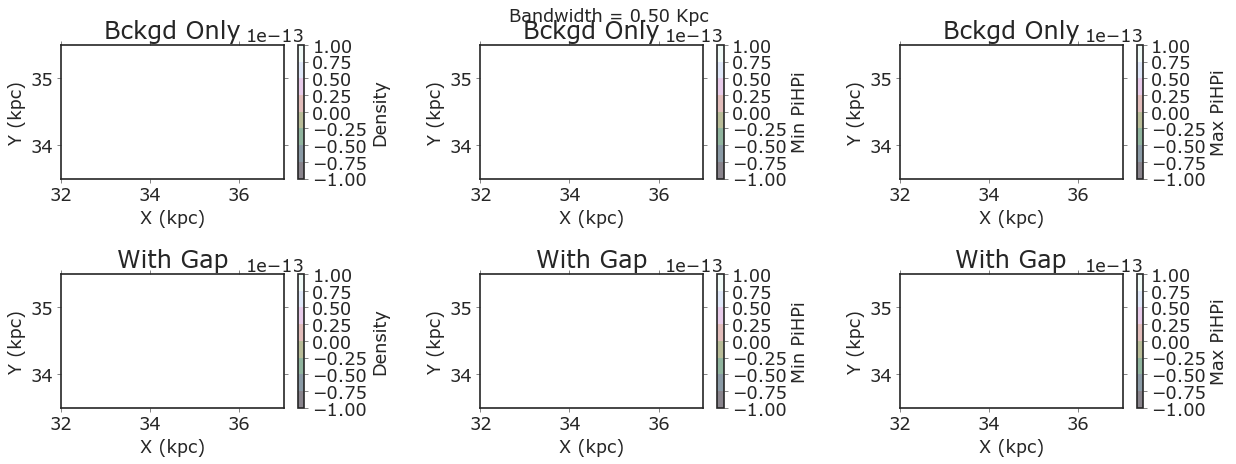

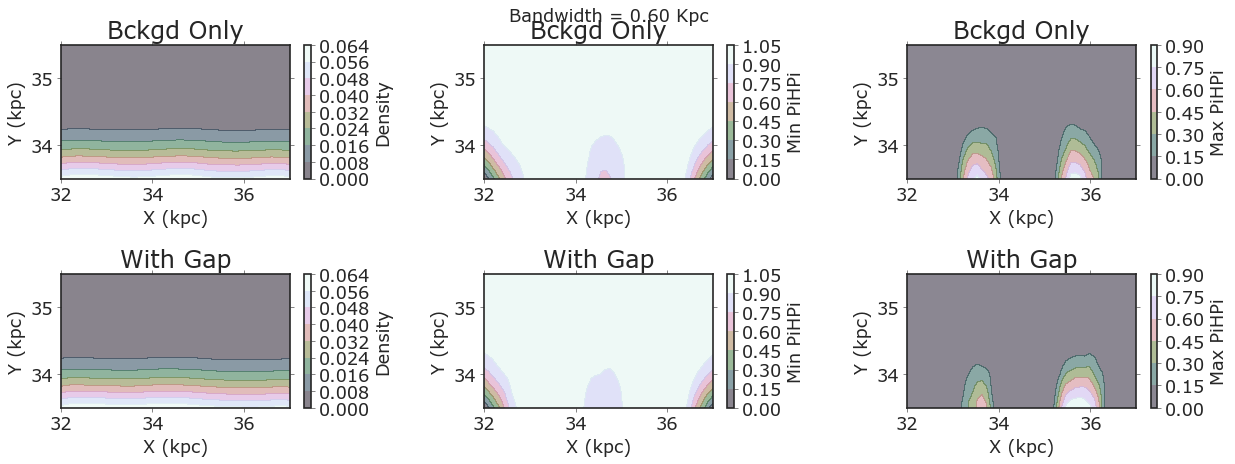

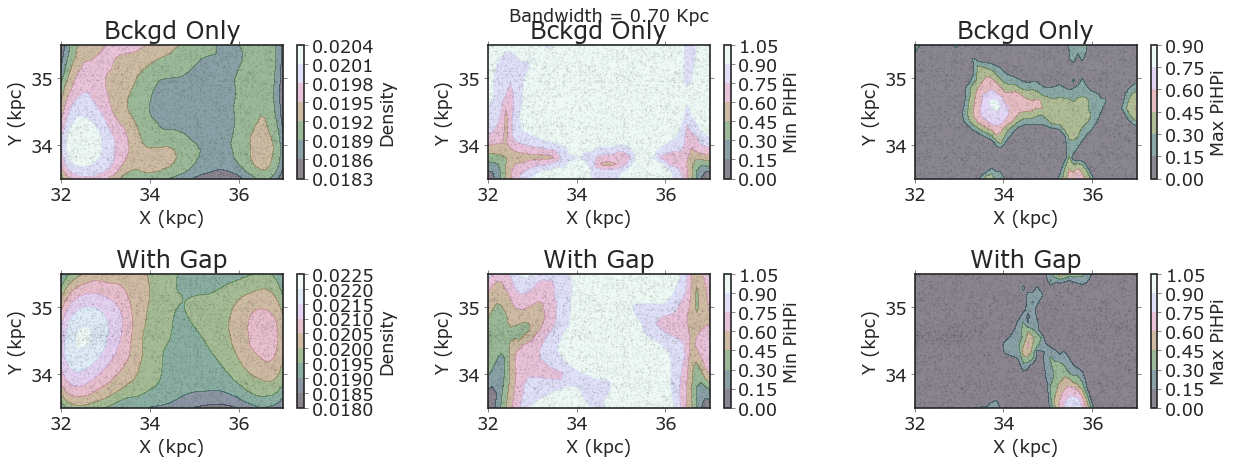

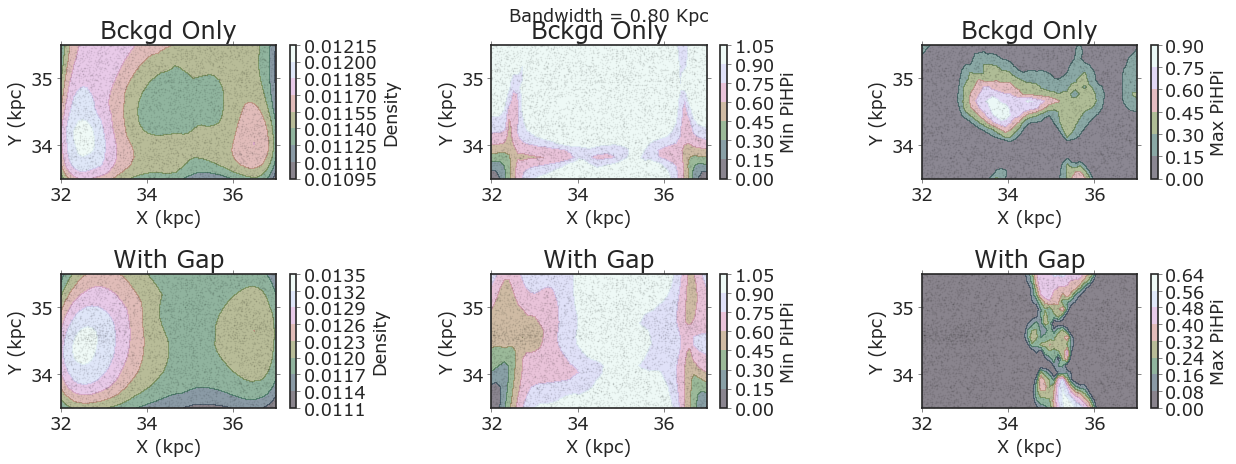

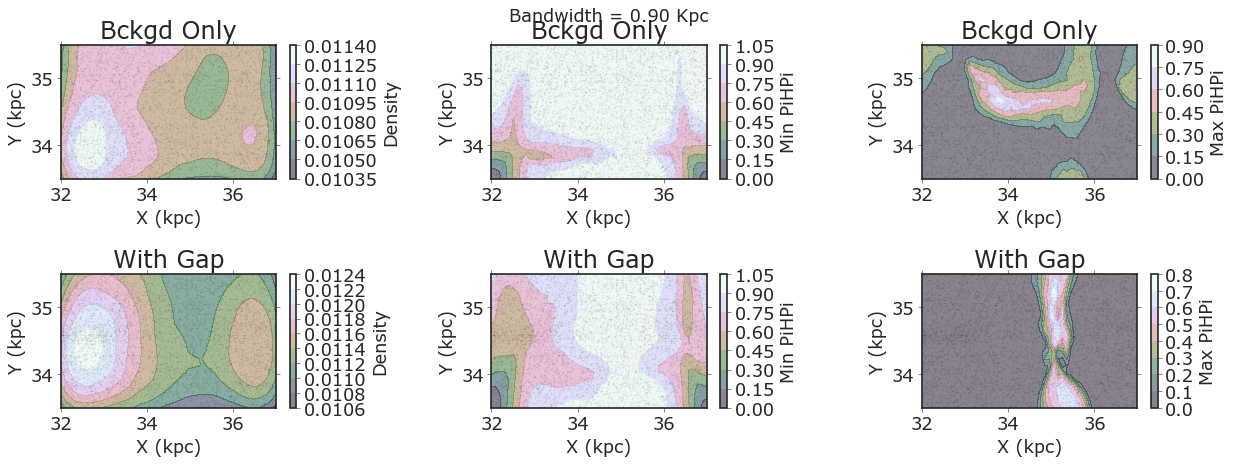

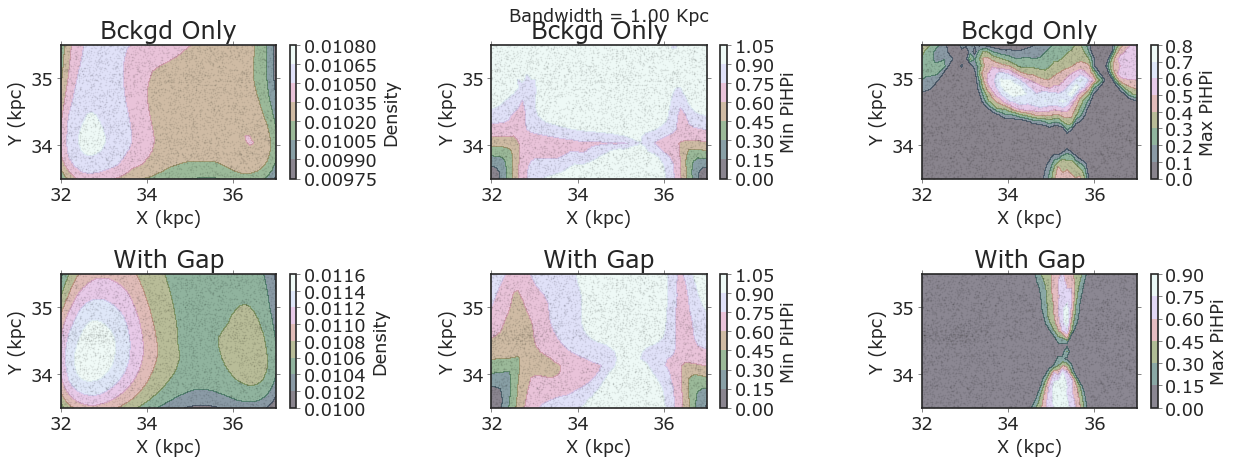

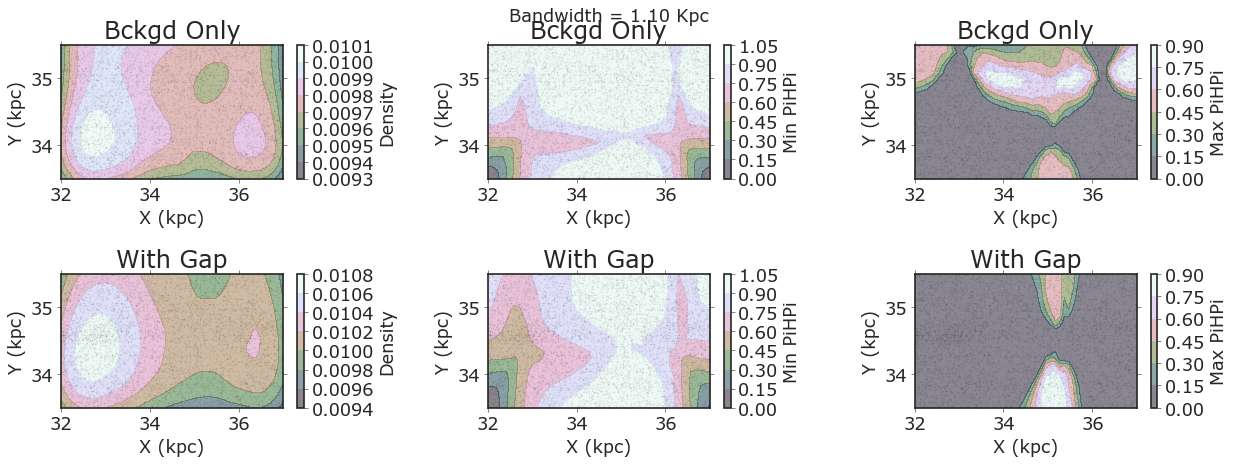

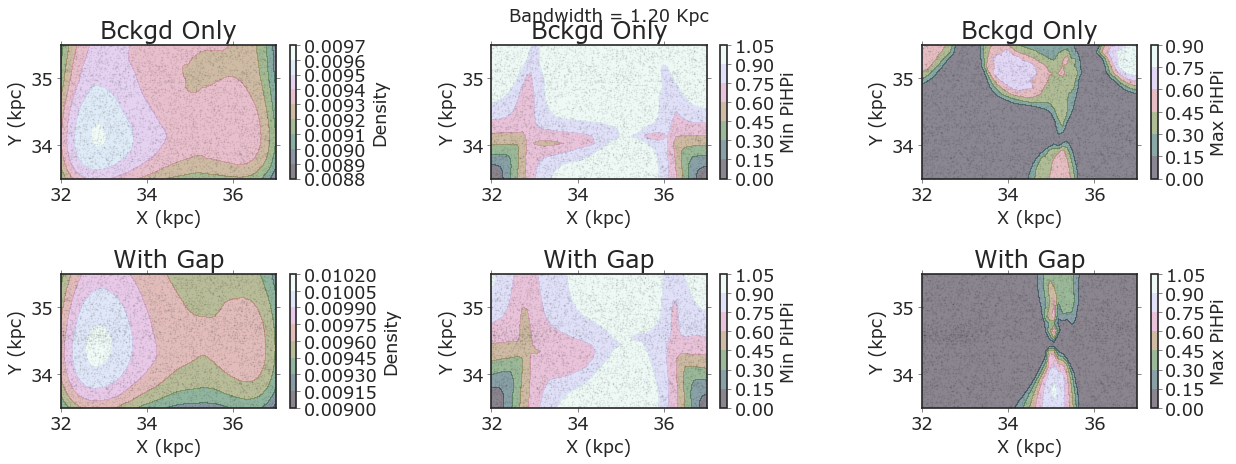

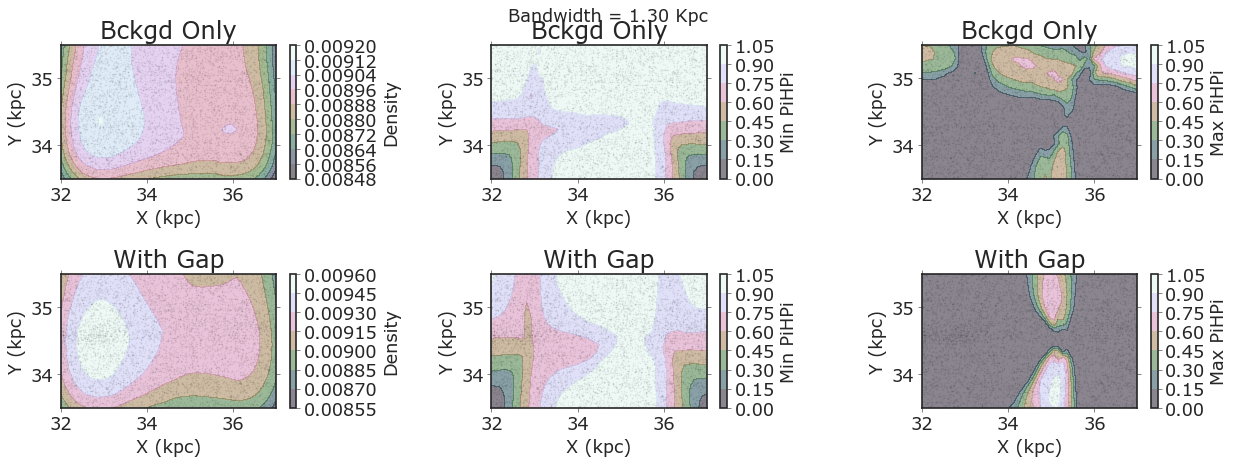

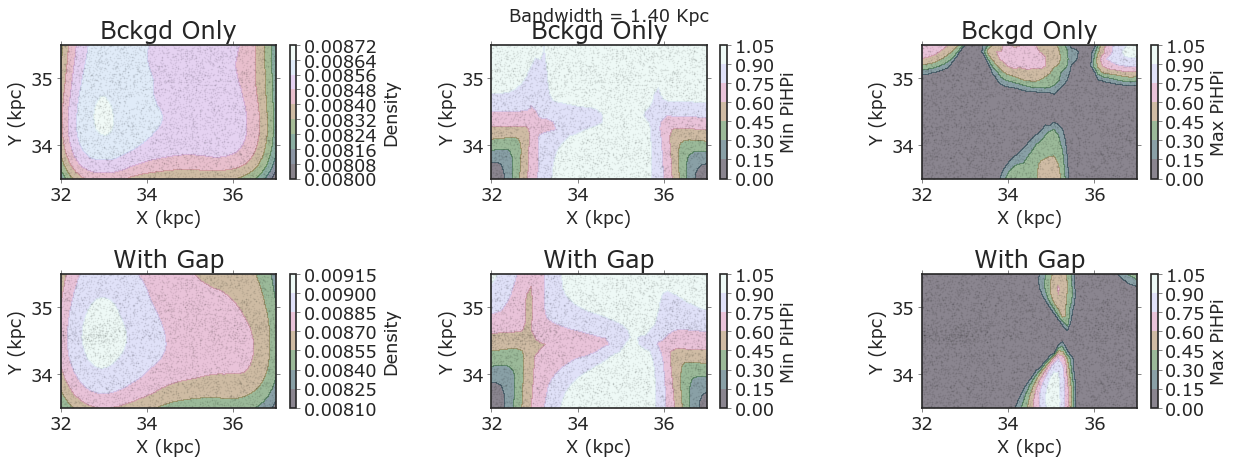

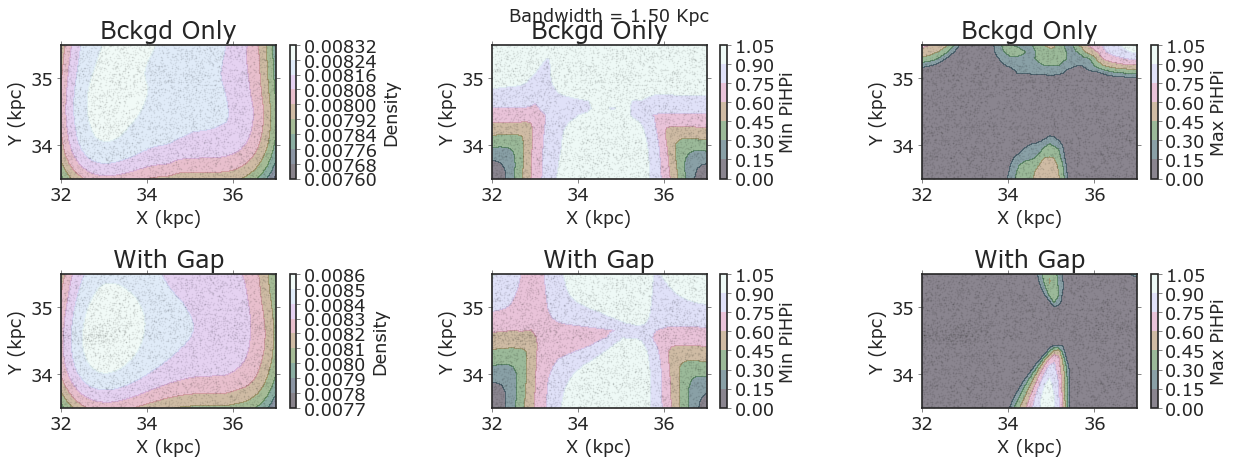

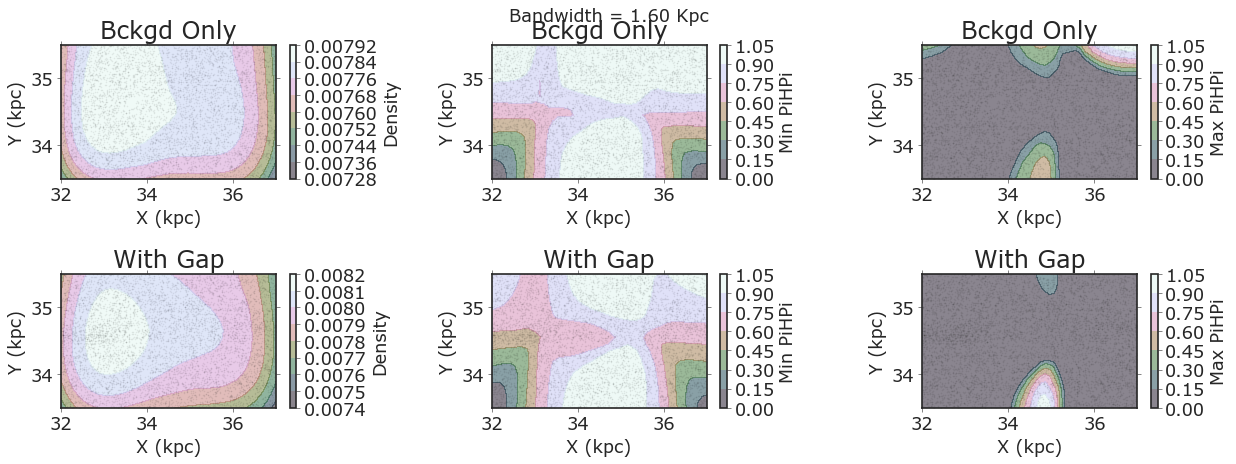

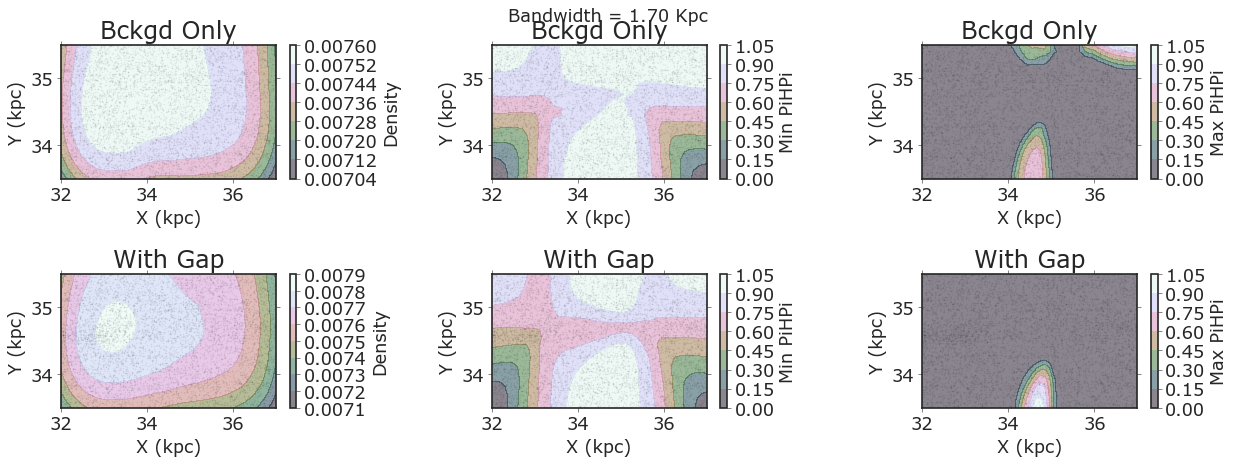

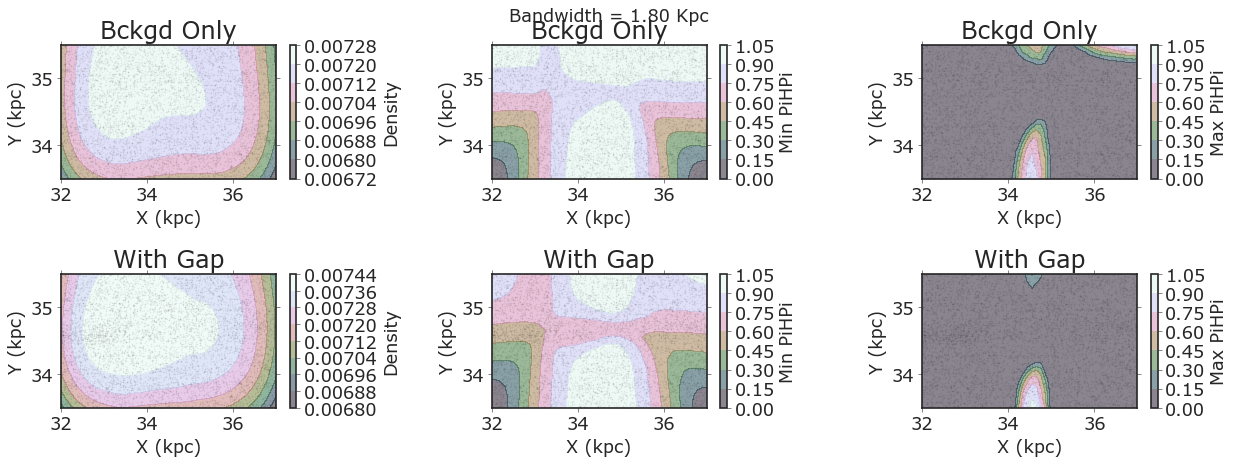

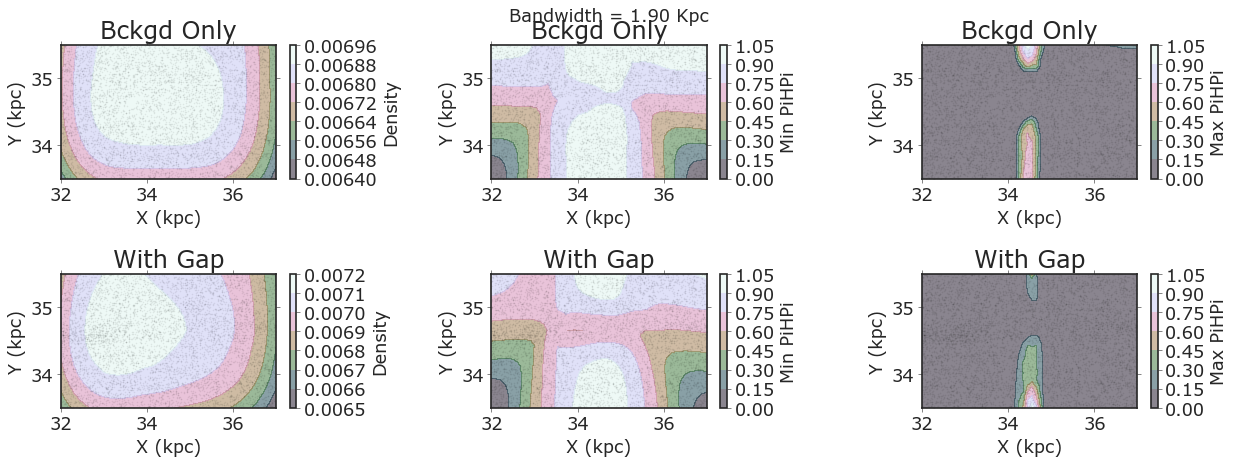

In [21]:
for bw in np.arange(0.5, 2, 0.1): 
    n=2
    boolean0=np.logical_and.reduce([data0[0] > 32-1.5*bw,
                                   data0[0] < 37+1.5*bw,

                                   data0[1] > 33.5-1.5*bw,
                                   data0[1] < 35.5*1.5*bw])

    boolean1=np.logical_and.reduce([data1[0] > 32-1.5*bw,
                                   data1[0] < 37+1.5*bw,

                                   data1[1] > 33.5-1.5*bw,
                                   data1[1] < 35.5*1.5*bw])
    
    data0_small=[data0[0][boolean0], data0[1][boolean0]]                 
    data1_small=[data1[0][boolean1], data1[1][boolean1]]  

    v0=get_density(np.array(data0_small).T, meshgrid, gridding_size, bw, nboot=10)
    v1=get_density(np.array(data1_small).T, meshgrid, gridding_size, bw, nboot=10)

    fig, ax=plt.subplots(figsize=(16, 6), ncols=3, nrows=2)

    c=ax[0][0].contourf(v0['meshgrid'][0],v0['meshgrid'][1], v0['density'], alpha=0.5, cmap='cubehelix')
    plt.colorbar(c, label='Density')

    c=ax[0][1].contourf(v0['meshgrid'][0],v0['meshgrid'][1], v0['min_eigen'], alpha=0.5, cmap='cubehelix')
    plt.colorbar(c, label='Min PiHPi')

    c=ax[0][-1].contourf(v0['meshgrid'][0],v0['meshgrid'][1], v0['max_eigen'], alpha=0.5, cmap='cubehelix')
    plt.colorbar(c, label='Max PiHPi')


    c=ax[1][0].contourf(v1['meshgrid'][0],v1['meshgrid'][1], v1['density'], alpha=0.5, cmap='cubehelix')
    plt.colorbar(c, label='Density')

    c=ax[1][1].contourf(v1['meshgrid'][0],v1['meshgrid'][1], v1['min_eigen'], alpha=0.5, cmap='cubehelix')
    plt.colorbar(c, label='Min PiHPi')

    c=ax[1][-1].contourf(v1['meshgrid'][0],v1['meshgrid'][1], v1['max_eigen'], alpha=0.5, cmap='cubehelix')
    plt.colorbar(c, label='Max PiHPi')

    plt.tight_layout()


    for a in ax[0]:
        a.scatter(data0_small[0], data0_small[1], s=0.1, alpha=0.1, c='k')
        xlim=[grid_data[:,0].min(), grid_data[:,0].max()]
        ylim=[grid_data[:,1].min(), grid_data[:,1].max()]
        a.set(xlim=xlim, ylim=ylim)
        a.set(xlabel='X (kpc)', ylabel='Y (kpc)', title='Bckgd Only')

    for a in ax[-1]:
        a.scatter(data1_small[0], data1_small[1], s=0.1, alpha=0.1, c='k')
        xlim=[grid_data[:,0].min(), grid_data[:,0].max()]
        ylim=[grid_data[:,1].min(), grid_data[:,1].max()]
        a.set(xlim=xlim, ylim=ylim)  
        a.set(xlabel='X (kpc)', ylabel='Y (kpc)', title='With Gap')

    plt.tight_layout()
    fig.suptitle('Bandwidth = {:.2f} Kpc'.format(bw))
    plt.savefig('../figures/diagnosticsbw{}.jpeg'.format(bw))



In [22]:
np.ptp(xlim)

5.0

In [23]:
np.random.choice(data0[0], len(data0[0]), replace=True)

array([33.35031479, 37.34676971, 33.89607925, ..., 34.13041879,
       35.09663306, 37.61822659])

In [24]:
d=np.array(data1_small).T

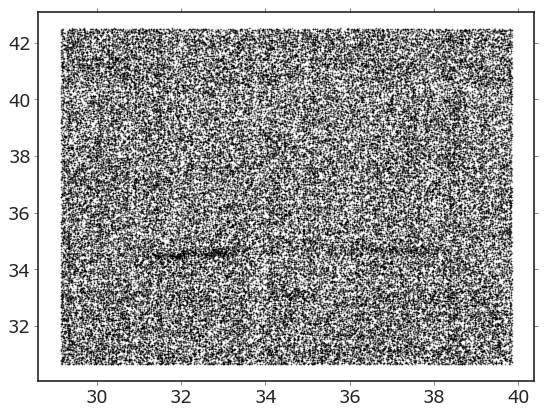

In [25]:
fig, ax=plt.subplots()
for x in range(0, 10):
    idx = np.random.randint(len(d), size=len(d))
    boot=d[idx,:]
    ax.scatter(boot[:,0], boot[:,1], s=.1, c='k', alpha=0.1)

In [39]:
import numpy as np
import numba

@numba.njit
def random_draw(x_grid, cdf, nsample=10):
    values = np.random.rand(nsample)
    value_bins = np.searchsorted(cdf, values)
    random_from_cdf = x_grid[value_bins]
    return random_from_cdf

# Normalize the CDF array before passing it to the function
x = np.arange(0, 10)
cdf = x**1/(x[-1]**1)
cdf = cdf / cdf[-1]
res = random_draw(x, cdf, 1e6)


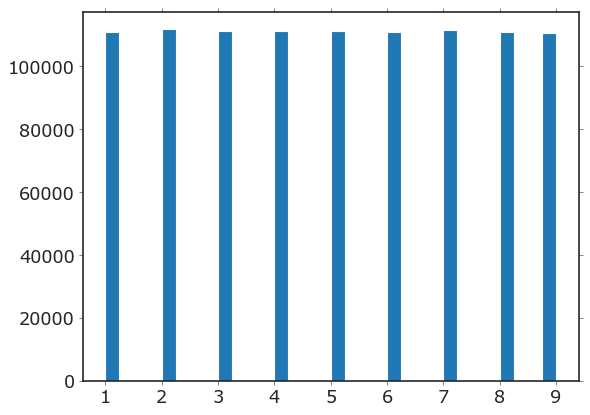

In [40]:
_= plt.hist(res, bins=32)

In [1]:
import numpy as np
import numba

@numba.jit(nopython=True)
def trapzl(y, x):
    s = 0
    for i in numba.prange(1, len(x)):
        s += (x[i]-x[i-1])*(y[i]+y[i-1])
    return s/2

x = np.arange(0, 10)
y = np.ones_like(x)
res = trapzl(y, x)


In [3]:
res

9.0